In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime as dt

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import keras_tuner as kt
import logging
import traceback
from sklearn.preprocessing import MinMaxScaler


In [45]:
data = pd.read_csv('temperature.csv',)

# Print the column names
print("Column names:", data.columns)

data.head(3) 

Column names: Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem'],
      dtype='object')


,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.83000,287.170000,307.59,305.47,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.83465,287.186092,307.59,304.31,310.495769,304.4,304.4,303.5


In [46]:
def auto_drop_na(data, drop_percent):
    # Calculate the number of rows as a reference for drop calculations
    num_rows = len(data)
    drop_threshold = num_rows * drop_percent / 100  # Convert percentage to actual number of rows
    
    print(f'Drop Percent of the rows is %{drop_percent}')
    print('If the number of NA values in a column is less than the calculated threshold, automatically drop the NA rows.')

    # Get the count of NAs in each column and convert to dictionary
    has_na = data.isna().sum()
    has_na = has_na[has_na > 0].to_dict()
    print(has_na)
    
    # Make decisions about null values
    columns_to_drop = ['datetime', 'Vancouver','Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']
    for column, na_count in has_na.items():
        if na_count > drop_threshold:
            print(f"The number of NA values in {column} is {na_count}, which is greater than the threshold {drop_threshold}. Review options before action.")
        else:
            print(f"Automatically dropping rows in {column} where NA values are present.")
            data.dropna(subset=[column], inplace=True)
    return data

# Example usage:
# Assuming 'data' is your DataFrame
data_cleaned = auto_drop_na(data, drop_percent=10)
data_cleaned

Drop Percent of the rows is %10
If the number of NA values in a column is less than the calculated threshold, automatically drop the NA rows.
{'Vancouver': 795, 'Portland': 1, 'San Francisco': 793, 'Seattle': 3, 'Los Angeles': 3, 'San Diego': 1, 'Las Vegas': 1, 'Phoenix': 3, 'Albuquerque': 1, 'Denver': 1, 'San Antonio': 1, 'Dallas': 4, 'Houston': 3, 'Kansas City': 1, 'Minneapolis': 13, 'Saint Louis': 1, 'Chicago': 3, 'Nashville': 2, 'Indianapolis': 7, 'Atlanta': 6, 'Detroit': 1, 'Jacksonville': 1, 'Charlotte': 3, 'Miami': 805, 'Pittsburgh': 3, 'Toronto': 1, 'Philadelphia': 3, 'New York': 793, 'Montreal': 3, 'Boston': 3, 'Beersheba': 798, 'Tel Aviv District': 793, 'Eilat': 792, 'Haifa': 798, 'Nahariyya': 797, 'Jerusalem': 793}
Automatically dropping rows in Vancouver where NA values are present.
Automatically dropping rows in Portland where NA values are present.
Automatically dropping rows in San Francisco where NA values are present.
Automatically dropping rows in Seattle where NA val

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.400,304.400,303.50
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.400,304.400,303.50
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.400,304.400,303.50
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.400,304.400,303.50
5,2012-10-01 17:00:00,284.622911,282.109095,289.431869,281.775065,291.852162,291.563063,293.370249,296.677445,285.392738,...,285.944057,288.485467,285.874069,287.322831,306.898887,304.194188,310.243077,304.400,304.400,303.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44456,2017-10-27 20:00:00,286.440000,293.840000,297.060000,286.150000,299.990000,299.390000,298.430000,302.150000,284.370000,...,290.600000,289.980000,283.120000,289.740000,287.578000,295.710000,297.150000,299.553,299.553,295.76
44457,2017-10-27 21:00:00,287.870000,294.850000,299.140000,288.140000,301.320000,299.700000,299.430000,303.650000,285.890000,...,290.330000,289.480000,283.120000,289.080000,287.578000,293.150000,298.150000,299.553,299.553,293.15
44458,2017-10-27 22:00:00,288.420000,295.570000,300.560000,289.440000,301.600000,300.160000,300.560000,304.480000,286.400000,...,288.490000,287.920000,282.120000,288.090000,287.578000,294.150000,297.150000,299.553,299.553,294.15
44459,2017-10-27 23:00:00,288.650000,294.990000,301.060000,290.590000,301.760000,300.770000,300.810000,304.950000,286.890000,...,286.160000,285.830000,281.770000,284.940000,285.944000,294.150000,291.019000,299.369,299.369,294.15


In [47]:
# data_cleaned = data_cleaned[['datetime', 'Vancouver']]
# Convert temperature from Kelvin to Celsius
data_cleaned['Vancouver_Celsius'] = data_cleaned['Vancouver'] - 273.15

# # Convert temperature from Kelvin to Fahrenheit
# data_cleaned['Vancouver_Fahrenheit'] = (data_cleaned['Vancouver'] - 273.15) * 9/5 + 32

data_cleaned

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,Vancouver_Celsius
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.400,304.400,303.50,11.480000
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.400,304.400,303.50,11.479041
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.400,304.400,303.50,11.476998
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.400,304.400,303.50,11.474955
5,2012-10-01 17:00:00,284.622911,282.109095,289.431869,281.775065,291.852162,291.563063,293.370249,296.677445,285.392738,...,288.485467,285.874069,287.322831,306.898887,304.194188,310.243077,304.400,304.400,303.50,11.472911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44456,2017-10-27 20:00:00,286.440000,293.840000,297.060000,286.150000,299.990000,299.390000,298.430000,302.150000,284.370000,...,289.980000,283.120000,289.740000,287.578000,295.710000,297.150000,299.553,299.553,295.76,13.290000
44457,2017-10-27 21:00:00,287.870000,294.850000,299.140000,288.140000,301.320000,299.700000,299.430000,303.650000,285.890000,...,289.480000,283.120000,289.080000,287.578000,293.150000,298.150000,299.553,299.553,293.15,14.720000
44458,2017-10-27 22:00:00,288.420000,295.570000,300.560000,289.440000,301.600000,300.160000,300.560000,304.480000,286.400000,...,287.920000,282.120000,288.090000,287.578000,294.150000,297.150000,299.553,299.553,294.15,15.270000
44459,2017-10-27 23:00:00,288.650000,294.990000,301.060000,290.590000,301.760000,300.770000,300.810000,304.950000,286.890000,...,285.830000,281.770000,284.940000,285.944000,294.150000,291.019000,299.369,299.369,294.15,15.500000


In [48]:
# import datetime as dt
# # Ensure 'datetime' is in datetime format
# # data_cleaned['datetime'] = pd.to_datetime(data_cleaned['datetime'])

# # # Extract date and hour
# # data_cleaned['date'] = data_cleaned['datetime'].dt.date
# data_cleaned['hour'] = data_cleaned['datetime'].dt.time
# data_cleaned['month'] = data_cleaned['datetime'].dt.month
# data_cleaned['day'] = data_cleaned['datetime'].dt.day


# # # Convert `date` to a numerical format (e.g., days since start of the dataset)
# # data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])
# # data_cleaned['date'] = (data_cleaned['date'] - data_cleaned['date'].min()).dt.days

# # # Convert `hour` to numerical format
# # data_cleaned['hour'] = pd.to_datetime(data_cleaned['hour'], format='%H:%M:%S').dt.hour

# data_cleaned

In [49]:
data_cleaned = data_cleaned[['datetime','Vancouver_Celsius']]

# Verify the result
data_cleaned.head()
data_cleaned.columns

Index(['datetime', 'Vancouver_Celsius'], dtype='object')

In [50]:
# Handle datetime column
datetime_col = 'datetime'
if datetime_col not in data_cleaned.columns:
    raise KeyError(f"The column '{datetime_col}' is not found in the dataset. Available columns: {data_cleaned.columns}")

data_cleaned[datetime_col] = pd.to_datetime(data_cleaned[datetime_col])



/var/folders/t7/hxd3pgr11qjblzs42br5s1_40000gn/T/ipykernel_28953/1076934662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[datetime_col] = pd.to_datetime(data_cleaned[datetime_col])


In [51]:
data_cleaned


,datetime,Vancouver_Celsius
1,2012-10-01 13:00:00,11.480000
2,2012-10-01 14:00:00,11.479041
3,2012-10-01 15:00:00,11.476998
4,2012-10-01 16:00:00,11.474955
5,2012-10-01 17:00:00,11.472911
...,...,...
44456,2017-10-27 20:00:00,13.290000
44457,2017-10-27 21:00:00,14.720000
44458,2017-10-27 22:00:00,15.270000
44459,2017-10-27 23:00:00,15.500000


In [52]:
# Handle datetime column
data_cleaned['datetime'] = pd.to_datetime(data_cleaned['datetime'])

# Add datetime features as columns
data_cleaned['day_of_year'] = data_cleaned['datetime'].dt.dayofyear
data_cleaned['hour_of_day'] = data_cleaned['datetime'].dt.hour
data_cleaned

/var/folders/t7/hxd3pgr11qjblzs42br5s1_40000gn/T/ipykernel_28953/673445703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['datetime'] = pd.to_datetime(data_cleaned['datetime'])
/var/folders/t7/hxd3pgr11qjblzs42br5s1_40000gn/T/ipykernel_28953/673445703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['day_of_year'] = data_cleaned['datetime'].dt.dayofyear
/var/folders/t7/hxd3pgr11qjblzs42br5s1_40000gn/T/ipykernel_28953/673445703.py:6: SettingWithCopyWarning: 
A value is tryin

,datetime,Vancouver_Celsius,day_of_year,hour_of_day
1,2012-10-01 13:00:00,11.480000,275,13
2,2012-10-01 14:00:00,11.479041,275,14
3,2012-10-01 15:00:00,11.476998,275,15
4,2012-10-01 16:00:00,11.474955,275,16
5,2012-10-01 17:00:00,11.472911,275,17
...,...,...,...,...
44456,2017-10-27 20:00:00,13.290000,300,20
44457,2017-10-27 21:00:00,14.720000,300,21
44458,2017-10-27 22:00:00,15.270000,300,22
44459,2017-10-27 23:00:00,15.500000,300,23


<Axes: xlabel='datetime'>

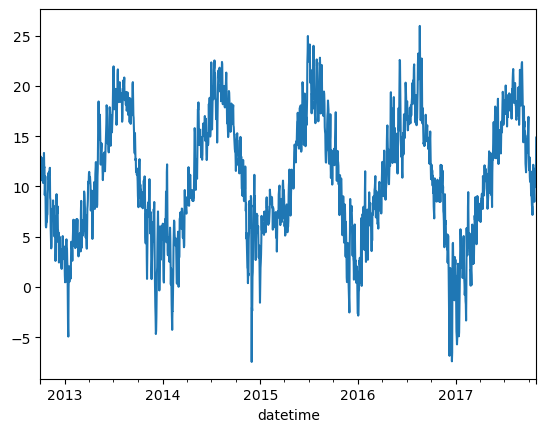

In [64]:
daily = data_cleaned.set_index('datetime')['Vancouver_Celsius'].resample('1D').mean()
daily.plot()

In [65]:
daily.head()

datetime
2012-10-01    11.470769
2012-10-02    12.995190
2012-10-03    12.378125
2012-10-04    11.223333
2012-10-05    10.607292
Freq: D, Name: Vancouver_Celsius, dtype: float64

In [124]:
def create_sequences(values, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(values) - seq_length):
        X_seq.append(values[i:i + seq_length])
        y_seq.append(values[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

In [177]:
seq_length = 15

In [178]:
X, y = create_sequences(daily.values, seq_length)

In [179]:
X.shape, y.shape

((1839, 15), (1839,))

In [180]:
mu = daily.values.mean()
sd = daily.values.std()

In [181]:
X_scaled = (X - mu)/sd

In [182]:
n = int(0.8*X_scaled.shape[0])

In [183]:
# Split the data
X_train, X_test, y_train, y_test =X_scaled[:n], X_scaled[n:], y[:n], y[n:]

In [184]:
X_train = X_train[:,:,None]
X_test = X_test[:,:,None]
X_train.shape

(1471, 15, 1)

In [185]:
def build_model(input_shape):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(LSTM(units=16,
                   activation='relu',                   
                   return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=8))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
    return model


In [186]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model  = build_model(X_train.shape[1:])

In [187]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32, callbacks=[early_stopping])


Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 150.9790 - mae: 10.7826 - val_loss: 132.8318 - val_mae: 9.9321
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137.2988 - mae: 10.2492 - val_loss: 91.1339 - val_mae: 8.0300
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92.4913 - mae: 7.9572 - val_loss: 84.2640 - val_mae: 7.6991
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.5941 - mae: 7.3569 - val_loss: 79.0883 - val_mae: 7.4494
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.7943 - mae: 7.4214 - val_loss: 74.7789 - val_mae: 7.2449
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.4041 - mae: 7.0354 - val_loss: 71.0829 - val_mae: 7.0669
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69.2703 - mae: 6.6745 - val_loss: 67.8348 - val_mae: 6.9121
Epoch 8/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.7421 - mae: 6.5060 - val_loss: 64.9328 - val_mae: 6.7699
Epoch 9/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [188]:
# Evaluate the model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

# Predict and calculate R^2 score
y_pred = model.predict(X_test).flatten()
test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {test_r2}")

Train MAE: 1.1758545637130737
Test MAE: 1.3193005323410034
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test R^2: 0.9377727040306344


In [189]:
def forecast(vals, seq_length, days):
    vals = vals.copy()
    y_pred = []
    X = np.array(vals[-seq_length:])[None, :]
    
    for i in range(days):
        X_scaled = (X - mu)/sd
        X_scaled = X_scaled[:,:,None]        
        y_cur = model.predict(X_scaled, verbose=0)[0,0]        
        y_pred.append(y_cur)
        vals.append(y_cur)
        X = np.array(vals[-seq_length:])[None, :]
    return y_pred
        

In [205]:
timestamps = 7
y_pred = forecast(daily.values.tolist(), seq_length, timestamps)


In [206]:
forecasted = pd.Series(y_pred, index=pd.date_range(daily.index[-1] + pd.Timedelta('1day'), 
                                                   daily.index[-1] + pd.Timedelta(timestamps, unit='D')))

In [207]:
forecasted

2017-10-29    14.307538
2017-10-30    13.812344
2017-10-31    13.362949
2017-11-01    13.052197
2017-11-02    12.899122
2017-11-03    12.855433
2017-11-04    12.894950
Freq: D, dtype: float32

<Axes: xlabel='datetime'>

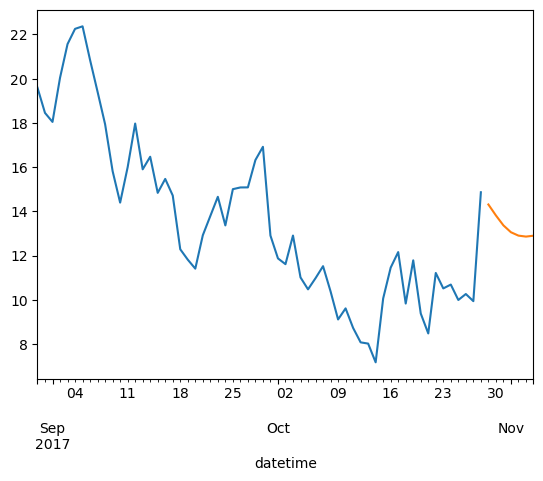

In [203]:
daily.iloc[-60:].plot()
forecasted.plot()

In [210]:
def predict_temperature(date):
    return forecasted[date]

In [211]:
import gradio as gr
# Create the Gradio interface
iface = gr.Interface(
    fn=predict_temperature,
    inputs=[
        gr.Dropdown(choices=forecasted.index.tolist())
    ],
    outputs="number",
    live=True,
    title="Temperature Forecast",
    description="Enter the day of the year and the hour of the day to get the forecasted temperature."
)

# Launch the interface
iface.launch(`share=True`)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
